$$\LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\d}{\mathrm{d}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Categorical}}
\newcommand{\Bin}{\mathrm{Binomial}}
$$

In [1]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;
import sklearn.mixture;

# ipython
import IPython;

# python
import os;
import random;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, 
                         (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import sys
sys.path.append('./code')
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.\
                You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);
        
    return render_func;

######################################################

# Markov Models

> Uses material from **[MLAPP]**

### Sequential Data

Some data has intrinsic sequential structure
- **Time Series:** Speech, EKGs, stock market, robot sensors, etc.
- **Spatial Data:** DNA, natural language, etc.

We could treat data points as iid samples
- e.g. "bag of words" assumption for spam classification
- But this is false!  We are ignoring valuable constraints in the data.

### Markov Models

A **Markov chain** is a series of random variables $X_1, \dots, X_N$ satisfying the *Markov property*:
> The future is independent of the past, given the present.
    $$
    p(x_n | x_1, \dots, x_{n-1}) = p(x_n | x_{n-1})
    $$
    
A chain is **stationary** if the transition probabilities do not change with time.

### Example:  [Random Shakespeare](http://www.cs.princeton.edu/courses/archive/spr05/cos126/assignments/markov.html)

```
DUKE SENIOR	Now, my co-mates and thus bolden'd, man, how now, monsieur Jaques,
	Unclaim'd of his absence, as the holly!
	Though in the slightest for the fashion of his absence, as the only wear.

TOUCHSTONE	I care not for meed!
	This I must woo yours: your request than your father: the time,
	That ever love I broke
	my sword upon some kind of men
	Then, heigh-ho! sing, heigh-ho! sing, heigh-ho! sing, heigh-ho! unto the needless stream;
	'Poor deer,' quoth he,
	'Call me not so keen,
	Because thou the creeping hours of the sun,
	As man's feasts and women merely players:
	Thus we may rest ourselves and neglect the cottage, pasture?

[Exit]
```

### Markov Models:  PGM

In [2]:
@pgm_render
def pgm_markov_chain():
    pgm = daft.PGM([6, 6], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("x1", r"$X_n$", 2, 2.5))
    pgm.add_node(daft.Node("x2", r"$X_2$", 3, 2.5))
    pgm.add_node(daft.Node("ellipsis", r" . . . ", 3.7, 2.5, 
                           offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("ellipsis_end", r"", 3.7, 2.5, 
                           offset=(0, 0), plot_params={"ec" : "none"}))
    pgm.add_node(daft.Node("xN", r"$X_N$", 4.5, 2.5))

    # Add in the edges.
    pgm.add_edge("x1", "x2", head_length=0.08)
    pgm.add_edge("x2", "ellipsis", head_length=0.08)
    pgm.add_edge("ellipsis_end", "xN", head_length=0.08)
    
    return pgm;

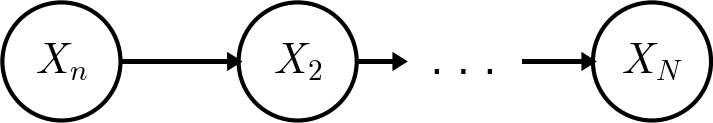

In [3]:
%%capture
pgm_markov_chain("images/markov-chain.png")

### Markov Models:  Joint Distribution

If a sequence has the Markov property, then the joint distribution factorizes according to
    $$
    p(x_1, \dots, x_N) = p(x_1) \prod_{n=2}^N p(x_n | x_{n-1})
    $$

### Example: Language Modeling

One important application is statistical **language models**.
- Bag-of-words assumption is inadequate
- Assume each word $X_t$ depends on the previous $n$ words

Can model longer-range dependencies
<table border=0px>
  <tr>
    <td>
*Zero-Order:* $P(X_t)$ <br>
*First-Order:* $P(X_t | X_{t-1})$<br>
*Second-Order:* $P(X_t | X_{t-1}, X_{t-2})$
    </td> 
    <td>
    <img src="images/2ndorder_markov.png" width=400px></td>
  </tr>
</table>

One we've learned an $n$th order Markov chain, we can use it to generate text!

### Markov Models:  Transition Matrix

Suppose $X_t \in \{1,\dots,K\}$ is discrete.  Then, a stationary chain with $N$ states can be described by a **transition matrix**, $A \in \R^{N \times N}$ where
    $$
    a_{ij} = p(X_t=j \mid X_{t-1}=i)
    $$

is the probability of transitioning from state $i$ to $j$.

> Each row sums to one, $\sum_{j=1}^K A_{ij} = 1$, so $A$ is a *row-stochastic matrix*.

### Markov Models:  Transition Diagram

Transitions between states can be represented as a graph:

<img src="images/murphy-fig174-markov.png">

> This is *not* a Bayesian network!

<span style="color:gray; font-size:10px; float:right">(Figure 17.4b from **[MLAPP]**)</span>

### Markov Models:  State Vectors

Consider a row vector $x_t \in \R^{K \times 1}$ with entries $x_{tj} = p(X_t = j)$.  Then,
    $$
    \begin{align}
    p(X_t = j)
    &= \sum_{i=1}^K p(X_t = j \mid X_{t-1} = i) p(X_{t-1} = i) \\
    &= \sum_{i=1}^K A_{ij} x_{t-1,i} \\
    \end{align}
    $$
Therefore, we conclude $x_t = x_{t-1} A$.  Note $\sum_{j=1}^K x_{tj} = 1$.

### Markov Models:  Matrix Powers

Since $x_t = x_{t-1} A$, this suggests that in general,
    $$
    x_{t} = x_{t-1} A = x_{t-2} A^2 = \cdots x_{0} A^t
    $$
If we know the initial state probabilities $x_0$, we can find the probabilities of landing in any state at time $t > 0$.

### Example:  Weather

Suppose the weather is either $R=\text{Rainy}$ or $S=\text{Sunny}$,
    $$
    A = \begin{bmatrix}
        0.9 & 0.1 \\
        0.5 & 0.5
    \end{bmatrix}
    $$

<img src="images/markov-chain-weather.png">

<span style="color:gray; font-size:10px; float:right">(Taken from [Wikipedia](https://en.wikipedia.org/wiki/Examples_of_Markov_chains#A_very_simple_weather_model))</span>

### Example:  Weather

Suppose today is sunny, $x_0 = \begin{bmatrix} 1 & 0 \end{bmatrix}$.  We can predict tomorrow's weather,
    $$
    x_1 = x_0 A = \begin{bmatrix} 0.9 & 0.1 \end{bmatrix}
    $$
The weather over the next several days will be
    $$
    \begin{align}
    x_2 &= x_1 A = \begin{bmatrix} 0.86 & 0.14 \end{bmatrix} \\
    x_3 &= x_2 A = \begin{bmatrix} 0.844 & 0.156 \end{bmatrix} \\
    x_4 &= x_3 A = \begin{bmatrix} 0.8376 & 0.1624 \end{bmatrix}
    \end{align}
    $$

> **Question:** What happens to $x_0 A^n$ as $n \rightarrow \infty$?

### Markov Chains:  Stationary Distribution

If we ever reach a stage $x$ where
    $$
    x = xA
    $$
then we have reached the **stationary distribution** of the chain.
- To find $x=v^T$, solve the eigenvalue problem $A^T v = v$
- Under certain conditions, the limiting distribution $\lim_{n \rightarrow \infty} x_0 A^n = x$
- Stationary distribution $x$ does not depend on the starting state $x_0$

# Hidden Markov Models

> Uses material from **[MLAPP]**

There are three fundamental problems for HMMs:

1. Evaluation: Given the model parameters and observed data, calculate the likelihood of the data.

2. Decoding: Given the model parameters and observed data, estimate the optimal sequence of hidden states.

3. Learning: Given just the observed data, estimate the model parameters.

The goal of the evaluation problem is to return the probability of a given sequence of observations given a sequence of latent states. Let us first introduce the toy problem. In this problem, we consider a person's latent state of health and their apparent symptoms. In this instance, a person is either Healthy or has a Fever, and the possible symptoms are feeling normal, cold, and dizzy. There is no deterministic relationship between the latent and observed states, so we need probabilistic approach to solving the problem of evaluation. 

<img src="./images/hmm1.png" height="500px">

In [1]:
states = ('Healthy', 'Fever')
end_state = 'E'
 
observations = ('cold', 'normal', 'normal')
 
start_probability = {'Healthy': 0.6, 'Fever': 0.4}

transition_probability = {
   'Healthy' : {'Healthy': 0.69, 'Fever': 0.3, 'E': 0.01},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.59, 'E': 0.01},
   }
 
emission_probability = {
   'Healthy' : {'normal': 0.5, 'cold': 0.4, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.3, 'dizzy': 0.6},
   }

### Hidden Markov Models

Noisy observations $X_k$ generated from *discrete* hidden Markov chain $Z_k$.
$$
P(\vec{X}, \vec{Z}) = P(Z_1) P(X_1 \mid Z_1) \prod_{k=2}^T P(Z_k \mid Z_{k-1}) P(X_k \mid Z_k)
$$

In [4]:
@pgm_render
def pgm_hmm():
    pgm = daft.PGM([7, 7], origin=[0, 0])

    # Nodes
    pgm.add_node(daft.Node("Z1", r"$Z_1$", 1, 3.5))
    pgm.add_node(daft.Node("Z2", r"$Z_2$", 2, 3.5))
    pgm.add_node(daft.Node("Z3", r"$\dots$", 3, 3.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("Z4", r"$Z_T$", 4, 3.5))

    pgm.add_node(daft.Node("x1", r"$X_1$", 1, 2.5, observed=True))
    pgm.add_node(daft.Node("x2", r"$X_2$", 2, 2.5, observed=True))
    pgm.add_node(daft.Node("x3", r"$\dots$", 3, 2.5, plot_params={'ec':'none'}))
    pgm.add_node(daft.Node("x4", r"$X_T$", 4, 2.5, observed=True))


    # Add in the edges.
    pgm.add_edge("Z1", "Z2", head_length=0.08)
    pgm.add_edge("Z2", "Z3", head_length=0.08)
    pgm.add_edge("Z3", "Z4", head_length=0.08)

    pgm.add_edge("Z1", "x1", head_length=0.08)
    pgm.add_edge("Z2", "x2", head_length=0.08)
    pgm.add_edge("Z4", "x4", head_length=0.08)
    
    return pgm;

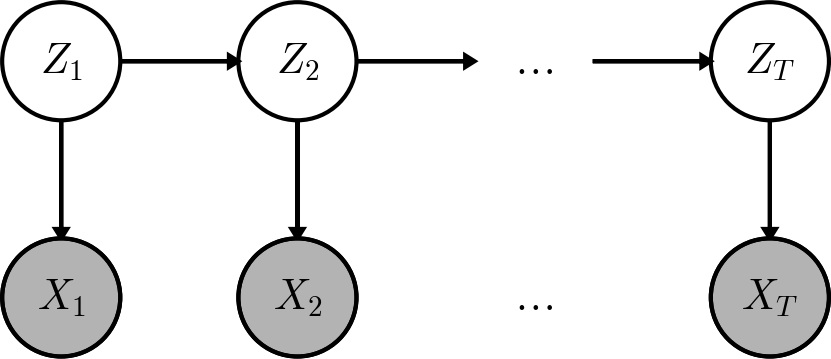

In [6]:
%%capture
pgm_hmm("images/hmm.png")

### HMM:  Parameters

For a Hidden Markov Model with $N$ hidden states and $M$ observed states, there are three *row-stochastic* parameters $\theta=(A,B,\pi)$,
- Transition matrix  $A \in \R^{N \times N}$
    $$
    A_{ij} = p(Z_t = j | Z_{t-1} = i)
    $$
- Emission matrix $B \in \R^{N \times M}$
    $$
    B_{jk} = p(X_t = k | Z_t = j)
    $$
- Initial distribution $\pi \in \R^N$,
    $$
    \pi_j = p(Z_1 = j)
    $$

### HMM:  Filtering Problem

**Filtering** means to compute the current *belief state* $p(z_t | x_1, \dots, x_t,\theta)$.
    $$
    p(z_t | x_1,\dots,x_t) = \frac{p(x_1,\dots,x_t,z_t)}{p(x_1,\dots,x_t)}
    $$
- Given observations $x_{1:t}$ so far, infer $z_t$.
- *Example*:  Estimate robot position given previous sensor readings.

> Solved by the **forward algorithm**.

### HMM:  Filtering Problem

As an example of filtering, consider **robot localization**, in which we 
- estimate the current location $z_t$
- given **noisy** sensor readings $x_1,\dots,x_t$.

<img src="images/murphy-fig183-filtering.png">

<span style="color:gray; font-size:10px; float:right">(Figure 18.3a from **[MLAPP]**)</span>

### HMM:  Forward Algorithm

The **forward algorithm** computes $\alpha_t(z_t) \equiv p(x_1,\dots,x_t,z_t)$.
    $$
    \begin{align}
    \alpha_t(z_t)
    &= \sum_{z_{t-1}} p(x_1, \dots, x_t, z_{t-1}, z_t) \\
    &= \sum_{z_{t-1}} p(x_1, \dots, x_{t-1}, z_{t-1}) p(z_t | z_{t-1}) p(x_t | z_t) \\
    &= p(x_t | z_t) \sum_{z_{t-1}} \alpha_{t-1}(z_{t-1}) p(z_t | z_{t-1})\\
    &= B_{z_t,x_t} \sum_{z_{t-1}} \alpha_{t-1}(z_{t-1}) A_{z_{t-1}, z_t}
    \end{align}
    $$

> Compute recursively starting from the *front* of the chain. The forward–backward algorithm can be used to find the most likely state for any point in time. It cannot, however, be used to find the most likely sequence of states (see Decoding, and specifically the Viterbi algorithm).

### HMM:  Smoothing Problem

Compute $p(z_t | \X)$ offline, given all observations.  
- Retroactively infer $z_t$.  (Hindsight!)

We can break the chain into two parts, the *past* and *future*:
    $$
    \begin{align}
    p(z_t | \X)
    &= p(x_{1:t}, z_t, x_{t+1:T}) \frac{1}{p(\X)} \\
    &= p(x_{1:t}, z_t) p(x_{t+1:T} | x_{1:t}, z_t)\frac{1}{p(\X)} \\
    &= p(x_{1:t}, z_t) p(x_{t+1:T} | z_t)\frac{1}{p(\X)}
    \end{align}
    $$

### HMM:  Smoothing Problem

Overall, the **smoothing problem** is to compute
$$
\begin{align*}
    \gamma_t(j) \equiv p(z_t = j \mid \X) 
    & = \frac{p(\X \mid z_t = j)p(z_t = j)}{p(\X)} \\
    & = \frac{p(\X_{1:t} \mid z_t = j) p(\X_{t+1:T} | z_t=j) p(z_t = j)}{p(\X)} \\
    & = \frac{\alpha_t(j) \beta_t(j)}{p(\X)} = \frac{\alpha_t(j) \beta_t(j)}{\sum_k \alpha_t(k)\beta_t(k)}
\end{align*}
$$
It is an easy exercise to check that, for any $t$, $p(\X) = \sum_k \alpha_t(k)\beta_t(x)$.

We solve this via the **forward-backward algorithm**, where
- $\alpha_t(z_t) \equiv p(x_1,\dots,x_t,z_t)$ is found with the **forward algorithm**
- $\beta_t(z_t) \equiv p(x_{t+1},\dots,x_{T} | z_t)$ is found with the **backward algorithm**



### HMM:  Backward Algorithm

The **backward algorithm** computes $\beta_t(z_t) \equiv p(x_{t+1},\dots,x_{T} | z_t)$,
    $$
    \begin{align}
    \beta(z_t)
    &= \sum_{z_{t+1}} p(x_{t+1},\dots,x_{T},z_{t+1} | z_t) \\
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}, \dots, x_T |z_{t+1}, z_t)\\
        (\text{since } x_{t+1:T} \perp z_t \mid z_{t+1}) \quad 
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}, \dots, x_T |z_{t+1})\\
        (\text{since } x_{t+2:T} \perp x_{t+1} \mid z_{t+1}) \quad 
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}|z_{t+1})  p(x_{t+2}, \dots, x_T |z_{t+1})\\
    &= \sum_{z_{t+1}} p(z_{t+1}|z_t) p(x_{t+1}|z_{t+1}) \beta_{t+1}(z_{t+1}) \\
    &= \sum_{z_{t+1}} A_{z_t, z_{t+1}} B_{z_{t+1}, x_{t+1}} \beta_{t+1}(z_{t+1})
    \end{align}
    $$

> Compute recursively starting from the *back* of the chain.

In [2]:
def fwd_bkw(y, states, a_0, a, e, end_st):
    L = len(y)
 
    fwd = []
    f_prev = {}
    # forward part of the algorithm
    for i, y_i in enumerate(y):
        f_curr = {}
        for st in states:
            if i == 0:
                # base case for the forward part
                prev_f_sum = a_0[st]
            else:
                prev_f_sum = sum(f_prev[k]*a[k][st] for k in states)
 
            f_curr[st] = e[st][y_i] * prev_f_sum
 
        fwd.append(f_curr)
        f_prev = f_curr
 
    p_fwd = sum(f_curr[k]*a[k][end_st] for k in states)
 
    bkw = []
    b_prev = {}
    # backward part of the algorithm
    for i, y_i_plus in enumerate(reversed(y[1:]+(None,))):
        b_curr = {}
        for st in states:
            if i == 0:
                # base case for backward part
                b_curr[st] = a[st][end_st]
            else:
                b_curr[st] = sum(a[st][l]*e[l][y_i_plus]*b_prev[l] for l in states)
 
        bkw.insert(0,b_curr)
        b_prev = b_curr
 
    p_bkw = sum(a_0[l] * e[l][y[0]] * b_curr[l] for l in states)
 
    # merging the two parts
    posterior = []
    for i in range(L):
        posterior.append({st: fwd[i][st]*bkw[i][st]/p_fwd for st in states})
 
    assert p_fwd == p_bkw
    return fwd, bkw, posterior

In [3]:
 fwd, bkw, posterior = fwd_bkw(observations, states, start_probability, 
                               transition_probability, emission_probability, end_state)
print (posterior)

[{'Healthy': 0.7523637371047066, 'Fever': 0.24763626289529342}, {'Healthy': 0.9154595401170142, 'Fever': 0.08454045988298578}, {'Healthy': 0.907504985311503, 'Fever': 0.09249501468849691}]


### HMM:  Decoding Problem

Decoding an HMM is answering the question: "Given the transition model, what is the most likely sequence of latent states that could have produced the observed states?" This is different than the evaulation problem because it predicts an entire sequence rather than giving a probability distribution over the latent states for each time step. 

A naive way of solving the decoding problem is simply by exhausting evaulation, i.e. to list all possible sequences of hidden states and finding the probability of the observed sequence for each of the combinations. The most probable sequence of hidden states is that combination that maximises P(observed sequence | hidden state sequence).

This approach is viable, but to find the most probable sequence by exhaustively calculating each combination is computationally expensive. As with the forward algorithm, we can use the time invariance of the probabilities to reduce the complexity of the calculation.


**Decoding** computes the most probable state sequence, given observations.
    $$
    \vec{z}^* = \arg\max_{z_1,\dots,z_T} p(z_1,\dots,z_T | x_1, \dots, x_T, \theta)
    $$

> The decoding problem is solved by the **Viterbi algorithm**, which uses dynamic programming.  See **[PRML]** or **[MLAPP]** for more details.

### Viterbi Algorithm

* Viterbi is another recursive procedure for computing the most likely sequence of hidden states.
* We define $V_t(z_t)$ to be the probability of the most likely sequence of states up to time $t$ *that ended in state* $z_t$, given observed data
* These $V(z_t)$ values satisfies the recursion:

\begin{align}
V_1(j) & = p(x_1 \mid z_1=j) = B_{x_1, j}\\
V_{t+1}(j) & = p(x_{t+1} \mid z_{t+1} = j) \max_{k} \bigg\{ V_{t}(k) p(z_{t+1} = j \mid z_t = k) \bigg\}\\
& = B_{x_{t+1},j} \max_{k} \bigg\{ V_{t}(k) A_{j,k} \bigg\}
\end{align}

* Can be computed very quickly!

In [4]:
# a slightly more realistic version of the 'Healthy' vs. 'Fever' model is outlined and then generated
import random
states = ('Healthy', 'Fever')
observations = ('normal', 'cold', 'dizzy')
start_probability = {'Healthy': 0.6, 'Fever': 0.4}

transition_probability = {
   'Healthy' : {'Healthy': 0.8, 'Fever': 0.2},
   'Fever' : {'Healthy': 0.4, 'Fever': 0.6}
   }

emission_probability = {
   'Healthy' : {'normal': 0.7, 'cold': 0.2, 'dizzy': 0.1},
   'Fever' : {'normal': 0.1, 'cold': 0.4, 'dizzy': 0.5}
   }

# A random HMM is generated using the probability matricies defined above
# Both the latent and visible states are generated in order to later assess the accuracy of our algorithms
N = 100
hidden = []
visible = []
# generate observations
if random.random() < start_probability[states[0]]:
    hidden.append(states[0])
else:
    hidden.append(states[1])

for i in range(N):
    current_state = hidden[i]
    if random.random() < transition_probability[current_state][states[0]]:
        hidden.append(states[0])
    else:
        hidden.append(states[1])
    r = random.random()
    prev = 0
    for observation in observations:
        prev += emission_probability[current_state][observation]
        if r < prev:
            visible.append(observation)
            break

# fixes issue of creating extra hidden state
hidden.pop()

'Healthy'

In [7]:
def print_dptable(V):
    s = "    " + " ".join(("%7d" % i) for i in range(len(V))) + "\n"
    for y in V[0]:
        s += "%.5s: " % y
        s += " ".join("%.7s" % ("%f" % v[y]) for v in V)
        s += "\n"
    print(s)

def viterbi(obs, states, start_p, trans_p, emit_p):
    V = [{}]
    path = {}
 
    # Initialize base cases (t == 0)
    for y in states:
        V[0][y] = start_p[y] * emit_p[y][obs[0]]
        path[y] = [y]
 
    # Run Viterbi for t > 0
    for t in range(1, len(obs)):
        V.append({})
        newpath = {}
 
        for y in states:
            (prob, state) = max((V[t-1][y0] * trans_p[y0][y] * emit_p[y][obs[t]], y0) for y0 in states)
            V[t][y] = prob
            newpath[y] = path[state] + [y]
 
        # Don't need to remember the old paths
        path = newpath
     
    #print_dptable(V)
    (prob, state) = max((V[t][y], y) for y in states)
    return (prob, path[state])

# input the generated markov model
def example():
    return viterbi(visible,
                   states,
                   start_probability,
                   transition_probability,
                   emission_probability)

(prob, p_hidden) = example()

# assess accuracy of the HMM model
wrong= 0
for i in range(len(hidden)):
    if hidden[i] != p_hidden[i]:
        wrong = wrong + 1
print ("accuracy: " + str(1-float(wrong)/N))

accuracy: 0.87



### HMM:  Part-of-Speech Tagging

In English, some words can have multiple parts of speech.  For instance,

- Business is going **well** (*Adverb*).
- All is **well** with us (*Adjective*).
- **Well**, who would have thought he could do it? (*Interjection*)
- The **well** was drilled fifty meters deep. (*Noun*)
- Tears **well** up in my eyes. (*Verb*)

<span style="color:gray; font-size:10px; float:right">(Example taken from [here](http://english.stackexchange.com/questions/46277/what-word-can-fulfill-the-most-parts-of-speech).)</span>

### HMM:  Part-of-Speech Tagging

We can use a Hidden Markov Model to **disambiguate** the part of speech using context clues!
- Hidden states $z_t$ are parts-of-speech
- Observed states $x_t$ are words

Certain sequences of POS tags are unlikely.  This allows us to infer the correct tags!

### HMM:  Learning Problem

It is usually necessary to **learn** the model parameters $\theta = (A,B,\pi)$ from data.
- Given observations $\mathcal{X} = \{ x_1, \dots, x_T \}$
- Given model dimensions $N$ and $M$
- Find parameters that best fit the data

> The learning problem is solved by the **Baum-Welch algorithm**, a special case of expectation maximization.

### Recall:  Expectation-Maximization

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Write down an expression for 
    $$
    Q(\theta_t, \theta) = E_{q}[ \log p(\X,Z | \theta) ] \quad \quad \text{ where } q = q(\cdot | \theta_t)
    $$
</div><div>
**M-Step:** Maximize the auxiliary function,
    $$
    \theta_{t+1}
    = \arg\max_\theta Q(\theta_t, \theta)
    $$
</div>
</div>

> Recall $q_t(Z) = p(Z|\X,\theta_t)$

### HMM:  Complete-Data Log-Likelihood

The joint likelihood of the hidden and observed states is

$$
\begin{align}
\log p(x_{1:T}, z_{1:T} | \theta)
&= \log \left[ p(z_1|\pi)
    \prod_{t=2}^T p(z_t | z_{t-1}, A)
    \prod_{t=1}^T p(x_t | z_t, B) \right] \\
&=  \log p(z_1|\pi)
    + \sum_{t=2}^T \log p(z_t | z_{t-1}, A) \\
    & \qquad \qquad + \sum_{t=1}^T \log p(x_t | z_t, B) 
\end{align}
$$

### HMM:  Complete-Data Log-Likelihood

Each term of the complete-data log-likelihood is:

$$
\begin{align}
\log p(z_1 | \pi)
    &= \sum_{j=1}^N \mathbb{I}(z_t=j) \log \pi_j \\
\log p(z_t | z_{t-1}, A)
    &= \sum_{i=1}^N \sum_{j=1}^N 
        \mathbb{I}(z_{t-1}=i)\mathbb{I}(z_t=j) \log A_{ij} \\
\log p(x_t | z_t, B)
    &= \sum_{j=1}^N 
        \mathbb{I}(z_t=j) \log B_{j,x_t} 
\end{align}
$$

### HMM:  Expected Complete Likelihood

The expected complete likelihood $Q(\theta_t, \theta)$ is

$$
\begin{align}
Q(\theta_t,\theta)
&= E_q[ \log p(\X,Z|\theta) ] \\
&= E_q[ \log p(z_1|\pi) ]
    + E_q\left[ \sum_{t=2}^T \log p(z_t | z_{t-1}, A) \right]\\
    &\qquad + E_q\left[ \sum_{t=1}^T \log p(x_t | z_t, B) \right]
\end{align}
$$

### HMM:  Expected Complete Likelihood

Fixing $t > 1$, and taking expectations with respect to $q(Z) = p(Z|\X,\theta)$,

$$
\begin{align*}
E_q[\log p(z_1 | \pi)]
    &= \sum_{j=1}^N q(z_1=j) \log \pi_j \\
E_q[\log p(z_t | z_{t-1}, A)]
    &= \sum_{i=1}^N \sum_{j=1}^N 
        q(z_{t-1}=i, z_t=j) \log A_{ij} \\
E_q[\log p(x_t | z_t, B)]
    &= \sum_{j=1}^N 
        q(z_t=j) \log B_{j, x_t} 
\end{align*}
$$


### HMM:  Baum-Welch

- The **E-Step** consists of computing the $q$ terms from the previous slide, which can all be computed using the **forward-backward algorithm**!

- The **M-Step** consists of normalizing the expected transition and emission counts
    - Similar to MLE for complete data
    - Requires some careful calculations. See details on next slide.

You must compute the key quantities for $q()$ using the forward-backward algorithm. In the E step you can assume the parameters $\theta = (A, B, \pi)$, so we'll drop dependence on $\theta$.
1. First note that $q(z_t=j) = p(z_t = j \mid \X, \theta) = \gamma_t(j)$ which we computed above.
1. Our last step is to compute $q(z_{t-1}=i, z_t=j) = p(z_{t-1}=i, z_t=j | \X, \theta)$. Again, dropping dependence on $\theta$, we have
$$ 
\begin{align*}
    p(z_{t-1}, z_t | \X, \theta)
    & = \frac{p(\X \mid z_t, z_{t-1})p(z_t, z_{t-1})}{p(\X)} \\
    & = \frac{p(\X_{1:t-1} \mid z_t, z_{t-1}) p(\X_{t:T} | z_t, z_{t-1}) p(z_t, z_{t-1})}{p(\X)} \\
    & = \frac{p(\X_{1:t-1} \mid z_{t-1}) p(\X_{t:T} | z_t) p(z_t, z_{t-1})}{p(\X)} \\
    & = \frac{p(\X_{1:t-1}, z_{t-1}) p(x_t \mid z_t) p(\X_{t+1:T} | z_t) p(z_t, z_{t-1})}{p(z_{t-1})p(\X)} \\
    & = \frac{\alpha_{t-1}(z_{t-1}) \beta_t(z_t) p(z_t \mid z_{t-1}) p(x_t \mid z_t)}{p(\X)} \\
    & = \frac{\alpha_{t-1}(z_{t-1}) \beta_t(z_t) A_{z_{t-1}, z_t} B_{z_t, x_t}}{\sum_k \alpha_t(k)\beta_t(k)}
\end{align*}
$$